In [ ]:
# default_exp las

# Las

> Basic functionalities to work and process point cloud (LAS/LAZ) files

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from pathlib import Path
import os
import random
import re
from tqdm import tqdm
tqdm.pandas()
from fastcore.test import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Simple plotting

In [ ]:
data_path = Path('data/')
example = '914153.las'

plot_x = 365188.3
plot_y = 6943847.83

In [ ]:
data = laspy.file.File(data_path/example, mode='r')

In [ ]:
# export
def plot_point_cloud(lasfile:laspy.file.File) -> plt.Axes:
    "Return 3d-projection of point cloud in ax"
    points = lasfile.points.copy()
    las_scaleX = lasfile.header.scale[0]
    las_scaleY = lasfile.header.scale[1]
    las_scaleZ = lasfile.header.scale[2]
    las_offsetX = lasfile.header.offset[0]
    las_offsetY = lasfile.header.offset[1]
    las_offsetZ = lasfile.header.offset[2]

    p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
    p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
    p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(p_X, p_Y, p_Z, c='r', marker='o')
    return ax

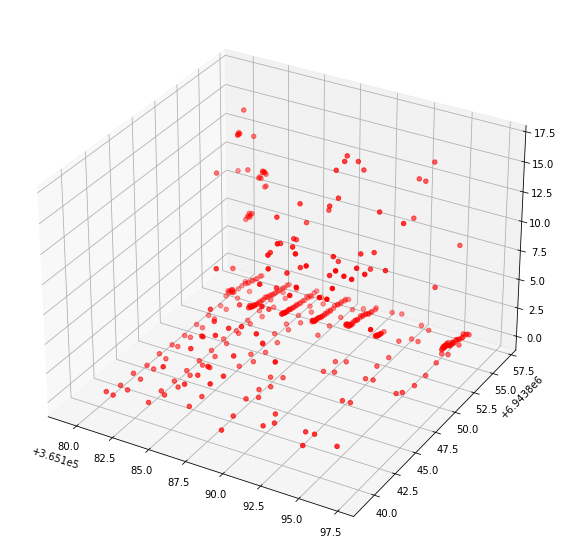

In [ ]:
plot_point_cloud(data)
plt.show()

In [ ]:
# export
def plot_2d_views(lasfile:laspy.file.File)-> plt.Axes:
    "Return X-Y, X-Z and Y-Z -views from lasfile"
    points = lasfile.points.copy()
    las_scaleX = lasfile.header.scale[0]
    las_scaleY = lasfile.header.scale[1]
    las_scaleZ = lasfile.header.scale[2]
    las_offsetX = lasfile.header.offset[0]
    las_offsetY = lasfile.header.offset[1]
    las_offsetZ = lasfile.header.offset[2]

    p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
    p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
    p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)
    fig, axs = plt.subplots(1,3, figsize=(13,4))
    axs[0].scatter(p_X, p_Y)
    axs[0].grid()
    axs[0].set_title('X=lon, Y=lat')
    axs[1].scatter(p_X, p_Z)
    axs[1].grid()
    axs[1].set_title('X=lon, Y=height')
    axs[2].scatter(p_Y, p_Z)
    axs[2].grid()
    axs[2].set_title('X=lat, Y=height')
    return axs

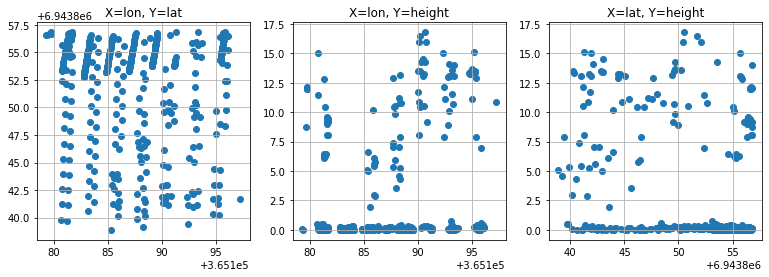

In [ ]:
plot_2d_views(data)
plt.show()

# LiDAR data for tabular models, used features from T. Tanhuanpää

In [ ]:
#export

def las_to_df(fn:str) -> pd.DataFrame:
    "Open .las-file and return it as dataframe with columns [x, y, z, num_returns, intensity]"
    lasfile = laspy.file.File(fn, mode='r')
    lidar_df = pd.DataFrame(columns=['x', 'y', 'z', 'num_returns', 'intensity'],
                            data=np.dstack((lasfile.x, lasfile.y, lasfile.z, lasfile.intensity, lasfile.num_returns))[0])
    lasfile.close()
    return lidar_df

def field_plot_circular(lidar_df:pd.DataFrame, plot_x:float, plot_y:float, radius:float=9) -> pd.DataFrame:
    "Select only the circular field plot area as used lidar data"
    lidar_df = lidar_df[lidar_df.apply(lambda row:np.linalg.norm(np.array([row.x, row.y]).T - np.array([plot_x, plot_y]).T) <= 9, axis=1)]
    return lidar_df
                        

In [ ]:
# export

def calc_metrics(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    "Calculate typical LiDAR-metrics from dataframe containing lidar information"
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    
    # Simple metrics
    hmax = vege_df.z.max() # maximum height
    hmean = vege_df.z.mean() # mean height
    hstd  = vege_df.z.std() # standard deviation for height
    pene = len(vege_df) / len(lidar_df) # penetration percentage
    cv = hstd / hmean # coefficient of variation
    imax = vege_df.intensity.max() # maximum intensity
    imean = vege_df.intensity.mean() # mean intensity
    imedian = vege_df.intensity.median() # median intensity
    
    # Height quantiles for returns above minimum height
    h10 = vege_df.z.quantile(0.1)
    h20 = vege_df.z.quantile(0.2)
    h30 = vege_df.z.quantile(0.3)
    h40 = vege_df.z.quantile(0.4)
    h50 = vege_df.z.quantile(0.5)
    h60 = vege_df.z.quantile(0.6)
    h70 = vege_df.z.quantile(0.7)
    h80 = vege_df.z.quantile(0.8)
    h90 = vege_df.z.quantile(0.9)
    h95 = vege_df.z.quantile(0.95)
    h98 = vege_df.z.quantile(0.98)
    h99 = vege_df.z.quantile(0.99)
    
    # Percentages of points in each height level above minimum height
    level = (hmax - min_h) * 0.1
    p_1 = vege_df[vege_df.z < (min_h + level)]
    p_2 = vege_df[vege_df.z < (min_h + 2 * level)]
    p_3 = vege_df[vege_df.z < (min_h + 3 * level)]
    p_4 = vege_df[vege_df.z < (min_h + 4 * level)]
    p_5 = vege_df[vege_df.z < (min_h + 5 * level)]
    p_6 = vege_df[vege_df.z < (min_h + 6 * level)]
    p_7 = vege_df[vege_df.z < (min_h + 7 * level)]
    p_8 = vege_df[vege_df.z < (min_h + 8 * level)]
    p_9 = vege_df[vege_df.z < (min_h + 9 * level)]
    p_95 = vege_df[vege_df.z < (min_h + 9.5 * level)]
    p_98 = vege_df[vege_df.z < (min_h + 9.8 * level)]
    p_99 = vege_df[vege_df.z < (min_h + 9.9 * level)]
    
    p10 = len(p_1)/len(vege_df)
    p20 = len(p_2)/len(vege_df)
    p30 = len(p_3)/len(vege_df)
    p40 = len(p_4)/len(vege_df)
    p50 = len(p_5)/len(vege_df)
    p60 = len(p_6)/len(vege_df)
    p70 = len(p_7)/len(vege_df)
    p80 = len(p_8)/len(vege_df)
    p90 = len(p_9)/len(vege_df)
    p95 = len(p_95)/len(vege_df)
    p98 = len(p_98)/len(vege_df)
    p99 = len(p_99)/len(vege_df)
    
    # number of points in each level
    p_no = len(vege_df)
    
    df_vals = [hmax, hmean, hstd, pene, cv, imax, imean, imedian, 
               h10, h20, h30, h40, h50, h60, h70, h80, h90, h95, h98, h99,
               p10, p20, p30, p40, p50, p60, p70, p80, p90, p95, p98, p99, p_no]   
    return df_vals

In [ ]:
example_df = las_to_df(data_path/example)
test_eq(type(example_df), pd.DataFrame)
example_df = field_plot_circular(example_df, plot_x, plot_y)
test_eq(type(example_df), pd.DataFrame)
example_metrics = calc_metrics(example_df)
test_eq(type(example_metrics), list)

# LAS-files to 2D-images

In [ ]:
# TODO

# LAS-files to 3D-voxels

Adapted from Elias Ayrey's implementaion

In [ ]:
# export
def voxel_grid_from_las(lasfile:laspy.file.File, plot_x:float, plot_y:float, bin_voxels:bool=False,
                        max_h:float=42., plot_size:float=9., bottom_voxels:bool=False, mask_plot:bool=False) -> np.ndarray:
    "Create voxel grid from lidar point cloud"
    coords = np.vstack((lasfile.x, lasfile.y, lasfile.z)).T
    min_vals = (plot_x-plot_size, plot_y-plot_size)
    
    # Should match to 30x30x30 voxels maybe
    num_bins = 61
    num_vert_bins = 126
    
    # Create bins and calculate histograms
    H, edges = np.histogramdd(coords, bins=(np.linspace(min_vals[0]-.001, min_vals[0] + 2*plot_size, num_bins + 1),
                                            np.linspace(min_vals[1]-.001, min_vals[1] + 2*plot_size, num_bins + 1),
                                            np.linspace(0, max_h, num_vert_bins+1)))
    
    if bin_voxels: H = np.where(H!=0,1,0)
    
    H = H.astype('int8')
    
    if bottom_voxels:
        for x, y in product(range(num_bins), range(num_bins)):
            if np.max(H[x,y]) == 0: max_idx_of_voxel = 0
            else: 
                max_idx_of_voxel = np.argwhere(H[x,y] == np.max(H[x,y])).max()
            for z in range(max_idx_of_voxel+1):
                H[x,y,z] = 1
    
    if mask_plot:
        center = (int(H.shape[0]/2), int(H.shape[1]/2))
        X, Y = np.ogrid[:H.shape[0], :H.shape[1]]
        dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)
        mask = dist_from_center <= H.shape[0]/2
        H[~mask,:] = 0
    
    return H

In [ ]:
voxel_grid = voxel_grid_from_las(data, plot_x, plot_y, bin_voxels=False)

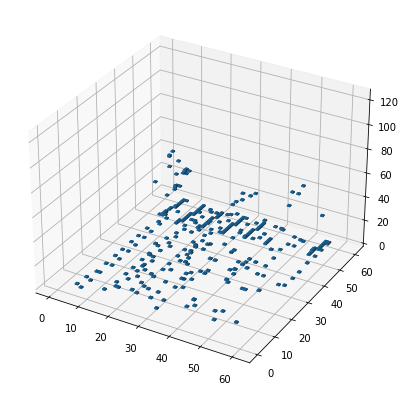

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.voxels(voxel_grid)
plt.show()

With mask_plot=True the voxel grid contains only the circular field plot

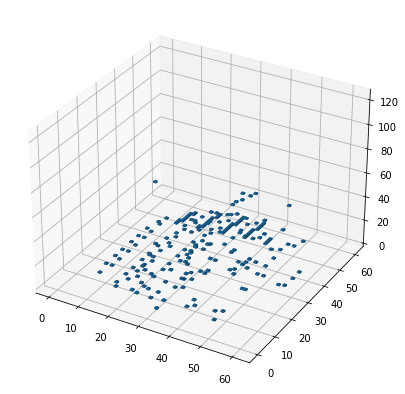

In [ ]:
voxel_grid = voxel_grid_from_las(data, plot_x, plot_y, bin_voxels=False, mask_plot=True)
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.voxels(voxel_grid)
plt.show()

With bottom_voxels = True and bin_voxels=true, we can plot also the "bottom areas" for voxels.

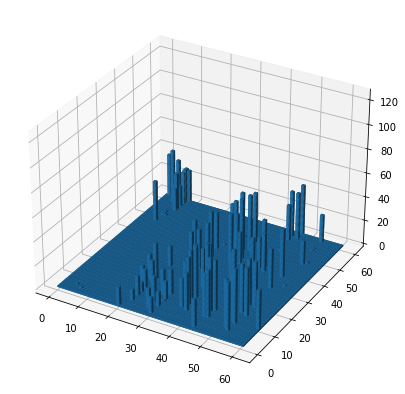

In [ ]:
voxel_grid = voxel_grid_from_las(data, plot_x, plot_y, bin_voxels=True, bottom_voxels=True, mask_plot=False)
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.voxels(voxel_grid)
plt.show()

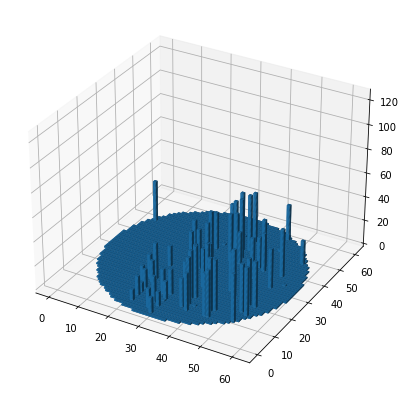

In [ ]:
voxel_grid = voxel_grid_from_las(data, plot_x, plot_y, bin_voxels=True, bottom_voxels=True, mask_plot=True)
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.voxels(voxel_grid)
plt.show()

In [ ]:
from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_image.ipynb.
Converted 01_las.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_ml_models.ipynb.
Converted 04_dl_models.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/enveco/nbs/00_image.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/01_las.ipynb
converting /mnt/d/Users/E1005164/enveco/nbs/index.ipynb to README.md
